In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import tensorflow as tf

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization
import keras.ops as ops

import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

from keras.layers import Embedding


text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng_extracted"/ "spa-eng" / "spa.txt"


/Users/fau/venv-metal/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [3]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [4]:
context_raw , target_raw  = load_data(text_file)
print(context_raw[-1])

BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


2025-03-21 22:31:07.267758: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-21 22:31:07.267780: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-21 22:31:07.267784: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1742617867.268342  309141 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742617867.268796  309141 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text
     

In [6]:
total_raw=(
    tf.data.Dataset
    .from_tensor_slices((context_raw, target_raw)))

max_vocab_size = 10000
sequence_length=25

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    output_sequence_length=sequence_length,
    ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]


2025-03-21 22:31:14.946656: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['',
 '[UNK]',
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('.'),
 np.str_('the'),
 np.str_('i'),
 np.str_('to'),
 np.str_('you'),
 np.str_('tom')]

In [7]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    output_sequence_length=sequence_length,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

2025-03-21 22:31:22.761338: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['',
 '[UNK]',
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('.'),
 np.str_('que'),
 np.str_('de'),
 np.str_('el'),
 np.str_('a'),
 np.str_('no')]

In [8]:

def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [9]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[   2  366   30  594   56  537   19    9 1982  299]

[   2   38  134   34  557 6964   19   10  894   11]
[  38  134   34  557 6964   19   10  894   11  180]


In [10]:
vectorizer_content=context_text_processor.get_vocabulary()
word_index_content=dict(zip(vectorizer_content, range(len(vectorizer_content))))

vectorizer_target=target_text_processor.get_vocabulary()
word_index_target=dict(zip(vectorizer_target, range(len(vectorizer_target))))

voc=vectorizer_target
word_index=word_index_target

In [ ]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
UNITS2 = 100

num_tokens = max_vocab_size
embedding_dim = UNITS2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])



Found 400000 word vectors.


In [ ]:


class Encoder2(tf.keras.layers.Layer):
  def __init__(self, text_processor, units,embedding_matrix):
    super(Encoder2, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(input_dim=self.vocab_size, 
                                               output_dim=units,weights=[embedding_matrix],trainable=False,
                                               mask_zero=True)


    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context
     
# Encode the input sequence.
encoder2 = Encoder2(context_text_processor, UNITS2, embedding_matrix)
ex_context2 = encoder2(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context2.shape}')
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x
     
attention_layer = CrossAttention(UNITS2)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS2, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context2)

print(f'Context sequence, shape (batch, s, units): {ex_context2.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')
     
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [ ]:

class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)
     
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(output, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits
     
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits
     
decoder = Decoder(target_text_processor, UNITS2)
logits = decoder(ex_context2, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context2.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  
  # Crear un estado inicial vacío (ceros) que sea compatible con el tamaño de las unidades del RNN.
  state = tf.zeros([batch_size, self.units], dtype=tf.float32)
  
  return start_tokens, done, state

@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ * START *', '')
  result = tf.strings.regex_replace(result, ' * END * $', '')
  return result
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context2)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context2, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

In [ ]:
class Translator3(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()

    encoder = Encoder2(context_text_processor, units, embedding_matrix)
    decoder = Decoder(target_text_processor, units)
    self.encoder = encoder
    self.decoder = decoder


  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits
     
#@title
def add_translate_method(class_type):
    @class_type.add_method
    def translate(self,
                  texts, *,
                  max_length=50,
                  temperature=0.0):
      # Process the input texts
      context = self.encoder.convert_input(texts)
      batch_size = tf.shape(texts)[0]

      # Setup the loop inputs
      tokens = []
      attention_weights = []
      next_token, done, state = self.decoder.get_initial_state(context)

      for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done,  state, temperature)
            
        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)
        
        if tf.executing_eagerly() and tf.reduce_all(done):
          break

      # Stack the lists of tokens and attention weights.
      tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
      self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

      result = self.decoder.tokens_to_text(tokens)
      return result

add_translate_method(Translator3)
def add_plot_attention_method(class_type):
    @class_type.add_method
    def plot_attention(self, text, **kwargs):
        assert isinstance(text, str)
        output = self.translate([text], **kwargs)
        output = output[0].numpy().decode()

        attention = self.last_attention_weights[0]

        context = tf_lower_and_split_punct(text)
        context = context.numpy().decode().split()

        output = tf_lower_and_split_punct(output)
        output = output.numpy().decode().split()[1:]

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)

        ax.matshow(attention, cmap='viridis', vmin=0.0)

        fontdict = {'fontsize': 14}

        ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
        ax.set_yticklabels([''] + output, fontdict=fontdict)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        ax.set_xlabel('Input text')
        ax.set_ylabel('Output text')

# Añadir la función a Translator1 y Translator2
add_translate_method(Translator3)
add_plot_attention_method(Translator3)


In [ ]:
model3 = Translator3(UNITS2, context_text_processor, target_text_processor)

logits = model3((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'decoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Context tokens, shape: (batch, s, units) (64, 19)
Target tokens, shape: (batch, t) (64, 16)
logits, shape: (batch, t, target_vocabulary_size) (64, 16, 10000)


/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model3.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()
{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': np.float32(9.2103405), 'expected_acc': 0.0001}

In [ ]:
model3.evaluate(val_ds, steps=20, return_dict=True)

2025-03-21 22:31:28.790417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 9.1882 - masked_acc: 1.4978e-04 - masked_loss: 9.1882


{'loss': 9.189016342163086,
 'masked_acc': 0.00018039814312942326,
 'masked_loss': 9.189016342163086}

In [ ]:
model3.summary()

Model: "translator2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder2_1 (Encoder2)           │ ?                      │     1,121,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │     2,111,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,232,400 (12.33 MB)

 Trainable params: 2,232,400 (8.52 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
history = model3.fit(
    train_ds.repeat(), 
    epochs=40,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 244ms/step - loss: 7.1029 - masked_acc: 0.1379 - masked_loss: 7.1029 - val_loss: 4.9725 - val_masked_acc: 0.2693 - val_masked_loss: 4.9725
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - loss: 4.8646 - masked_acc: 0.2906 - masked_loss: 4.8646 - val_loss: 4.3911 - val_masked_acc: 0.3380 - val_masked_loss: 4.3911
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - loss: 4.3034 - masked_acc: 0.3566 - masked_loss: 4.3034 - val_loss: 3.9343 - val_masked_acc: 0.3800 - val_masked_loss: 3.9343
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - loss: 3.8973 - masked_acc: 0.3979 - masked_loss: 3.8973 - val_loss: 3.6110 - val_masked_acc: 0.4309 - val_masked_loss: 3.6110
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - loss: 3.6185 - masked_acc: 0.4307 - masked_loss: 3.6185 - val_loss: 3.3082 - val_masked_acc: 0.4657 - val_masked_loss: 3.3082
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - loss: 3.3260 - masked_acc: 0

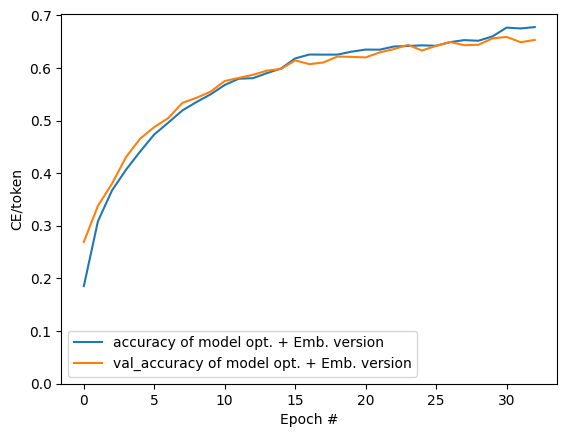

In [38]:
plt.plot(history.history['masked_acc'], label='accuracy of model opt. + Emb. version')
plt.plot(history.history['val_masked_acc'], label='val_accuracy of model opt. + Emb. version')

plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_3784/1866308677.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn

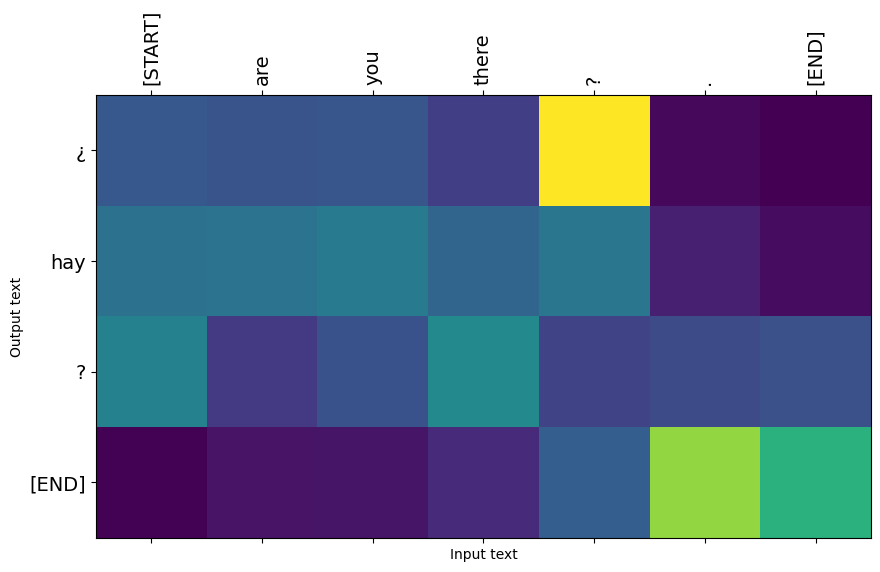

In [ ]:
model3.plot_attention('Are you there?.') # Are you still home

In [40]:
context=[]
target=[]
for context1, target1 in val_raw:
    context.append(context1)
    target.append(target1)


2025-03-21 22:43:14.609385: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_3784/1866308677.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn

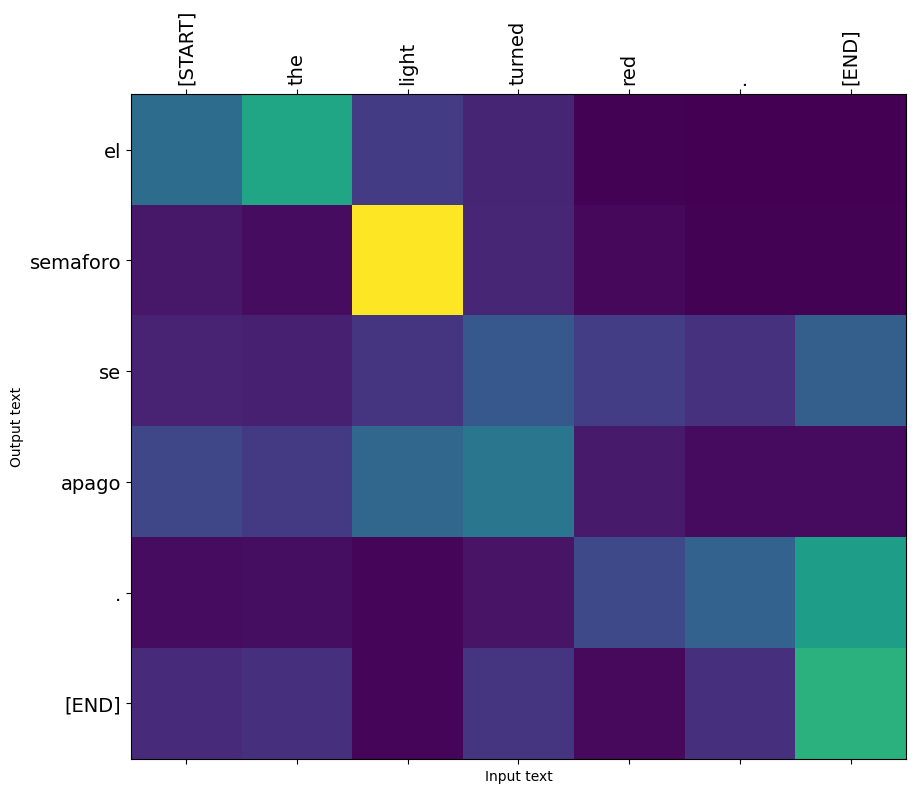

In [70]:
model.plot_attention(context[0][17].numpy().decode('utf-8')) 

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_3784/1866308677.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn

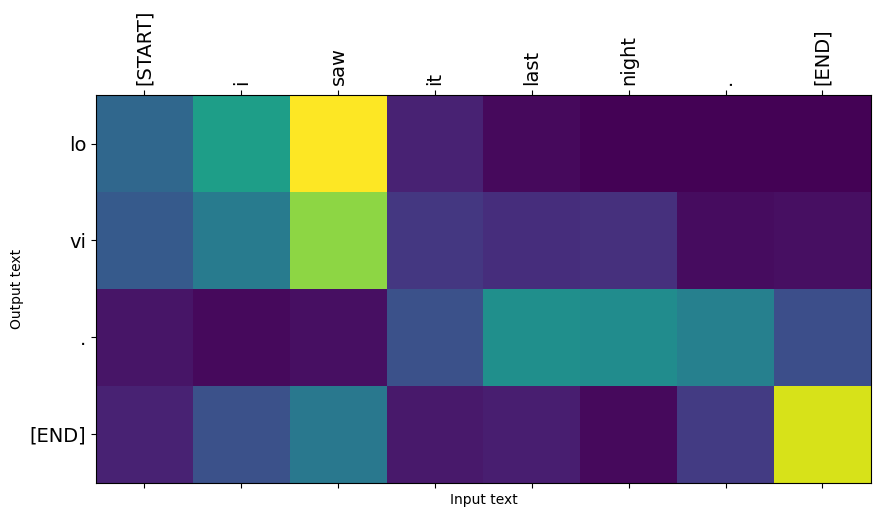

In [58]:
model.plot_attention(context[0][6].numpy().decode('utf-8')) 

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_3784/1866308677.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn

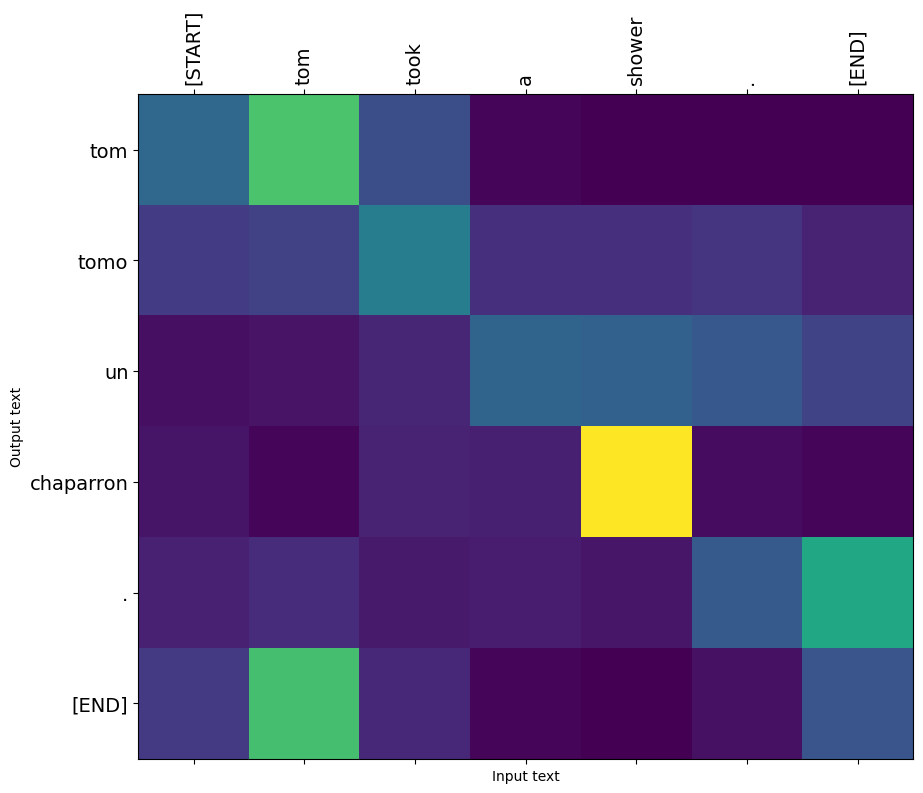

In [75]:
model.plot_attention(context[0][18].numpy().decode('utf-8')) 

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_3784/1866308677.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn

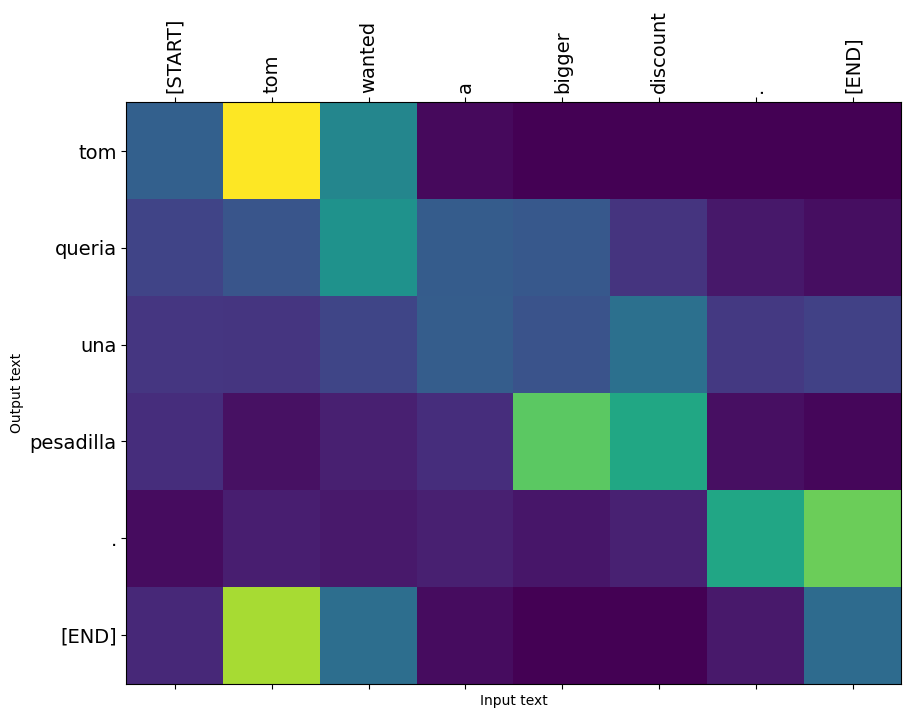

In [83]:
model.plot_attention(context[0][27].numpy().decode('utf-8')) 

In [87]:
reference_sentences=[]
translated_sentences=[]

for i in range(0,30):
    input_sentence = context[0][i].numpy().decode('utf-8')
    #print(input_sentence)
    translated_sentence=model.translate([context[0][i].numpy().decode('utf-8')]).numpy()[0].decode('utf-8')
    translated_sentence=(
        translated_sentence.replace("[START]","")
        .replace("[UNK]","")
        .replace("[END]",""))
    #print(type(translated_sentence))
    reference_sentences.append(target[0][i].numpy().decode('utf-8'))
    #print(type(target[0][i].numpy().decode('utf-8')))
    #print(target[0][i].numpy().decode('utf-8'))
    translated_sentences.append(translated_sentence)
    #print(translated_sentence)

import keras_nlp
rouge= keras_nlp.metrics.RougeN(order=1)
rouge2= keras_nlp.metrics.RougeN(order=2)
blue= keras_nlp.metrics.Bleu(max_order=1)
blue2= keras_nlp.metrics.Bleu(max_order=2)
print("Blue score, order 1 = ",blue(reference_sentences, translated_sentence))
print("Blue score, order 2 = ",blue2(reference_sentences, translated_sentence))
print("Rouge score, order 1 = ",rouge(reference_sentences, translated_sentences))
print("Rouge score, order 2 = ",rouge2(reference_sentences, translated_sentences))

Blue score, order 1 =  <Variable path=bleu/bleu, shape=(), dtype=float32, value=0.03999999910593033>
Blue score, order 2 =  <Variable path=bleu/bleu, shape=(), dtype=float32, value=0.0>
Rouge score, order 1 =  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.09250462800264359>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.25696006417274475>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.10637784749269485>}
Rouge score, order 2 =  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.04353741183876991>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.09595238417387009>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.040219202637672424>}


In [ ]:
class ‹(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)
  

export = Export(model)


In [ ]:
%%time
tf.saved_model.save(export, 'translator_tres',
                    signatures={'serving_default': export.translate})

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mas

INFO:tensorflow:Assets written to: translator_tres/assets


INFO:tensorflow:Assets written to: translator_tres/assets


CPU times: user 8.04 s, sys: 150 ms, total: 8.19 s
Wall time: 8.34 s
